In [23]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import nrrd
from scipy.spatial.distance import directed_hausdorff

import pyvista as pv
pv.set_plot_theme("document")
pv.start_xvfb()

### for enabling latex with pyvista
import vtk
vtk_mathtext = vtk.vtkMathTextFreeTypeTextRenderer()
vtk_mathtext.MathTextIsSupported()

True

In [3]:
image, _ = nrrd.read("../../data/ASOCA/Normal/CTCA/Normal_17.nrrd")

truth_path = "../../data_flat/Annotation_Normal_17.nrrd"
nrrd_data, nrrd_header = nrrd.read(truth_path)
lbl = np.array(nrrd_data)

prediction_path = "../../project/model1_auto3dseg/segresnet_0/prediction_testing/CTCA_Normal_17.nii.gz"
prediction_nib = nib.load(prediction_path)
pred = np.array(prediction_nib.dataobj)

im_shape = pred.shape

12

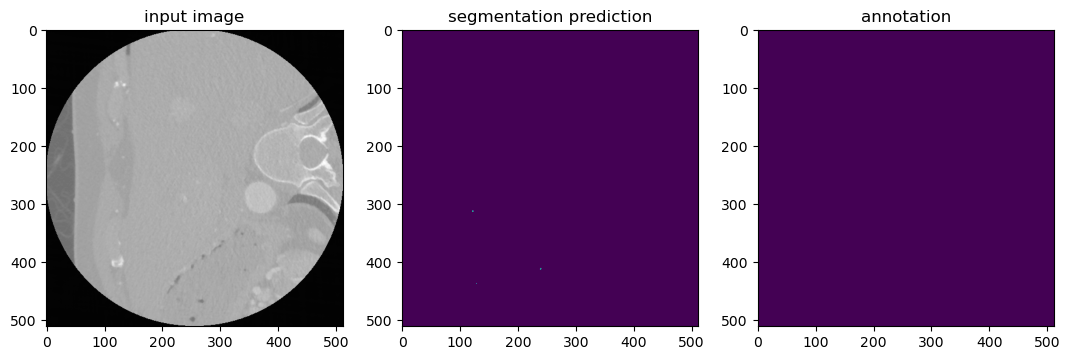

In [3]:
i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")
arr = lbl[:,:,i].astype(float)
arr[arr == 0] = np.nan
axs[0].imshow(arr, cmap="bwr_r")

axs[1].set_title("segmentation prediction")
axs[1].imshow(pred[:,:,i], cmap="viridis")

axs[2].set_title("annotation")
axs[2].imshow(lbl[:,:,i], cmap="viridis")

i

In [4]:
lbl.shape

(512, 512, 224)

In [5]:
# Create a 3D mesh
mesh = pv.wrap(lbl)

# take only the detected aortas (value = 1)
# contour = mesh.contour([1], "values")

contour = mesh.extract_points(mesh["values"] == 1)

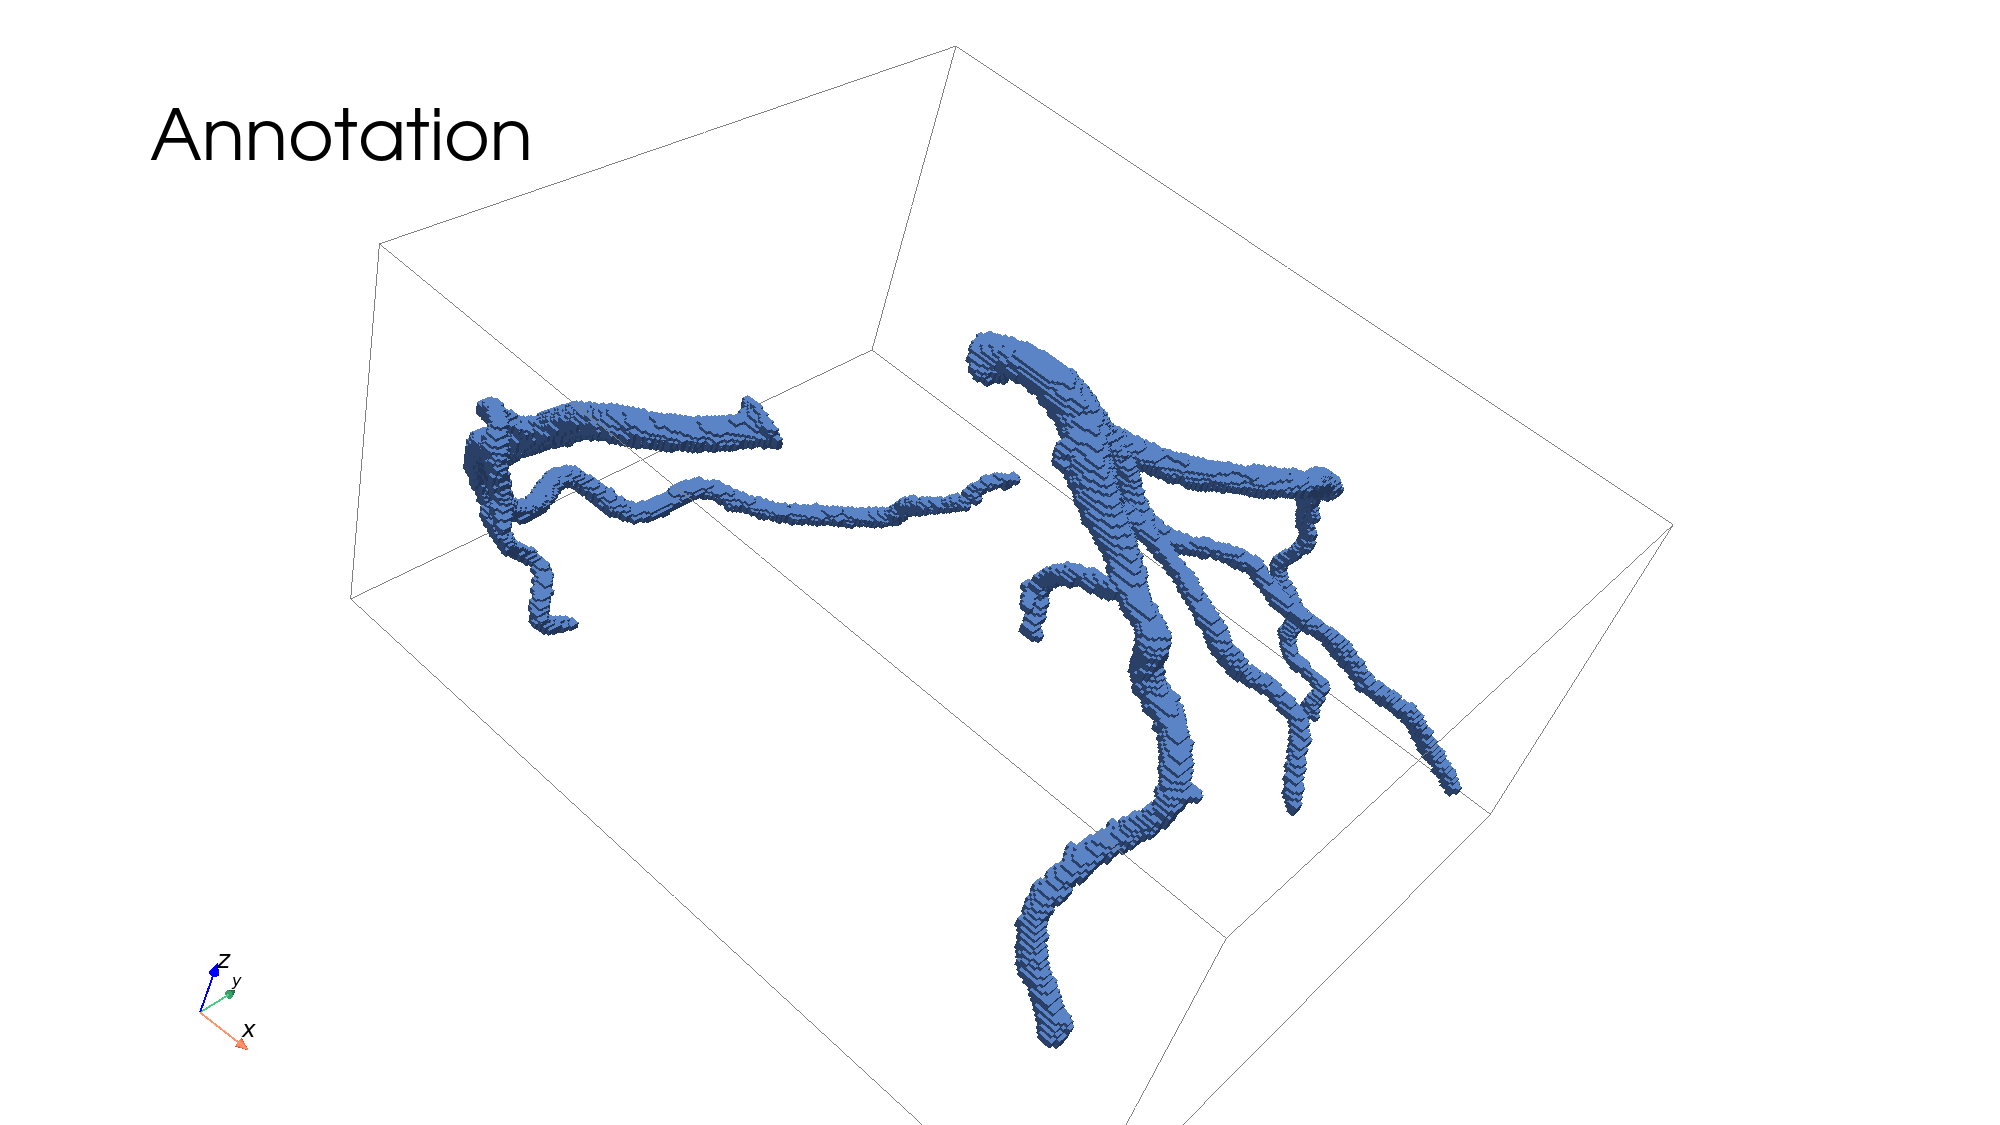

In [6]:
res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Annotation", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

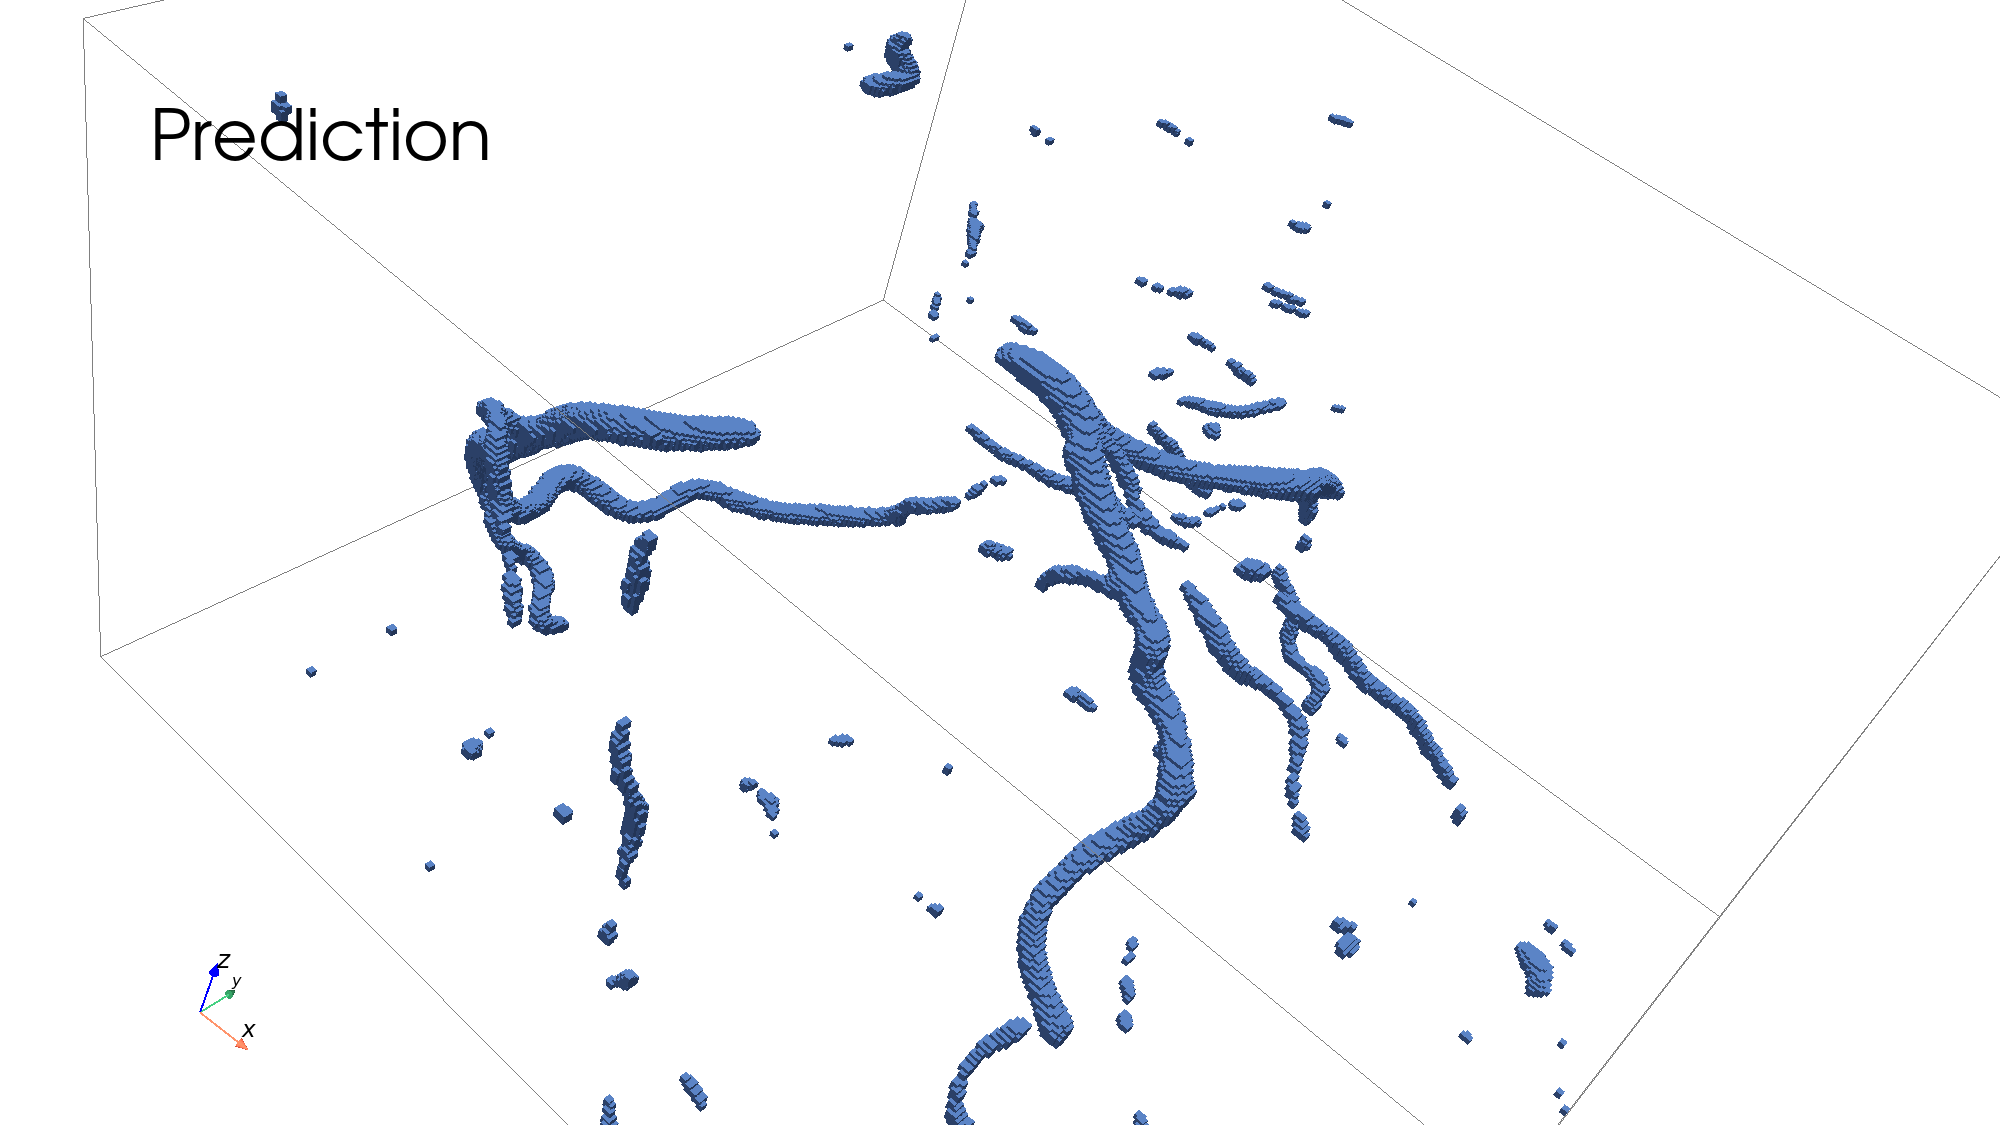

In [7]:
# Create a 3D mesh
mesh_2 = pv.wrap(pred)

# take only the detected aortas (value = 1)
# contour_2 = mesh_2.contour([1], "values")
contour_2 = mesh_2.extract_points(mesh_2["values"] == 1)


res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_2, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Prediction", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [8]:
## postprocessing: remove unconnected and small components

from scipy.cluster import hierarchy

# Extract the surface as a NumPy array
surface = contour_2.points

# Compute pairwise distances between surface points
distances = hierarchy.distance.pdist(surface)

# Apply hierarchical clustering to the distances
n_clusters = 40     # Number of initial clusters
clusters = hierarchy.fcluster(hierarchy.linkage(distances), t=n_clusters, criterion='maxclust')


# Extract the points in each cluster
cluster_points = []
for i in range(1, n_clusters+1):
    cluster_mask = clusters == i
    cluster_points.append(surface[cluster_mask])


# set threshold to remove small structures
cluster_threshold = 400
cluster_points = [cl for cl in cluster_points if len(cl)>cluster_threshold]

In [9]:
# # Plot each cluster with a different color
# plotter = pv.Plotter(window_size=(res, int(9/16*res)))

# for i in range(len(cluster_points)):
#     cluster_mesh = pv.PolyData(cluster_points[i])
#     cluster_mesh['cluster'] = np.full(len(cluster_points[i]), i+1, dtype=int)
#     plotter.add_mesh(cluster_mesh, scalars='cluster', opacity=0.5, cmap="turbo",
#                         # https://matplotlib.org/stable/tutorials/colors/colormaps.html
#                         scalar_bar_args=dict(title='Cluster', position_x=0.18, position_y=0.9, color="k", font_family='Times',
#                         n_labels=len(cluster_points), height=0.075, title_font_size=int(0.0175*res), label_font_size=int(0.015*res), fmt="%.0f"))      

# plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
#  (290.5, 274.0, 120.0),
#  (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(jupyter_backend='static')

In [10]:
contour_2_postproc = pv.PolyData(np.concatenate(cluster_points))

np_ndarr = np.zeros(im_shape, dtype=int)
contour_2_indices = contour_2_postproc.points.astype(int)
np_ndarr[contour_2_indices[:, 0], contour_2_indices[:, 1], contour_2_indices[:, 2]] = 1

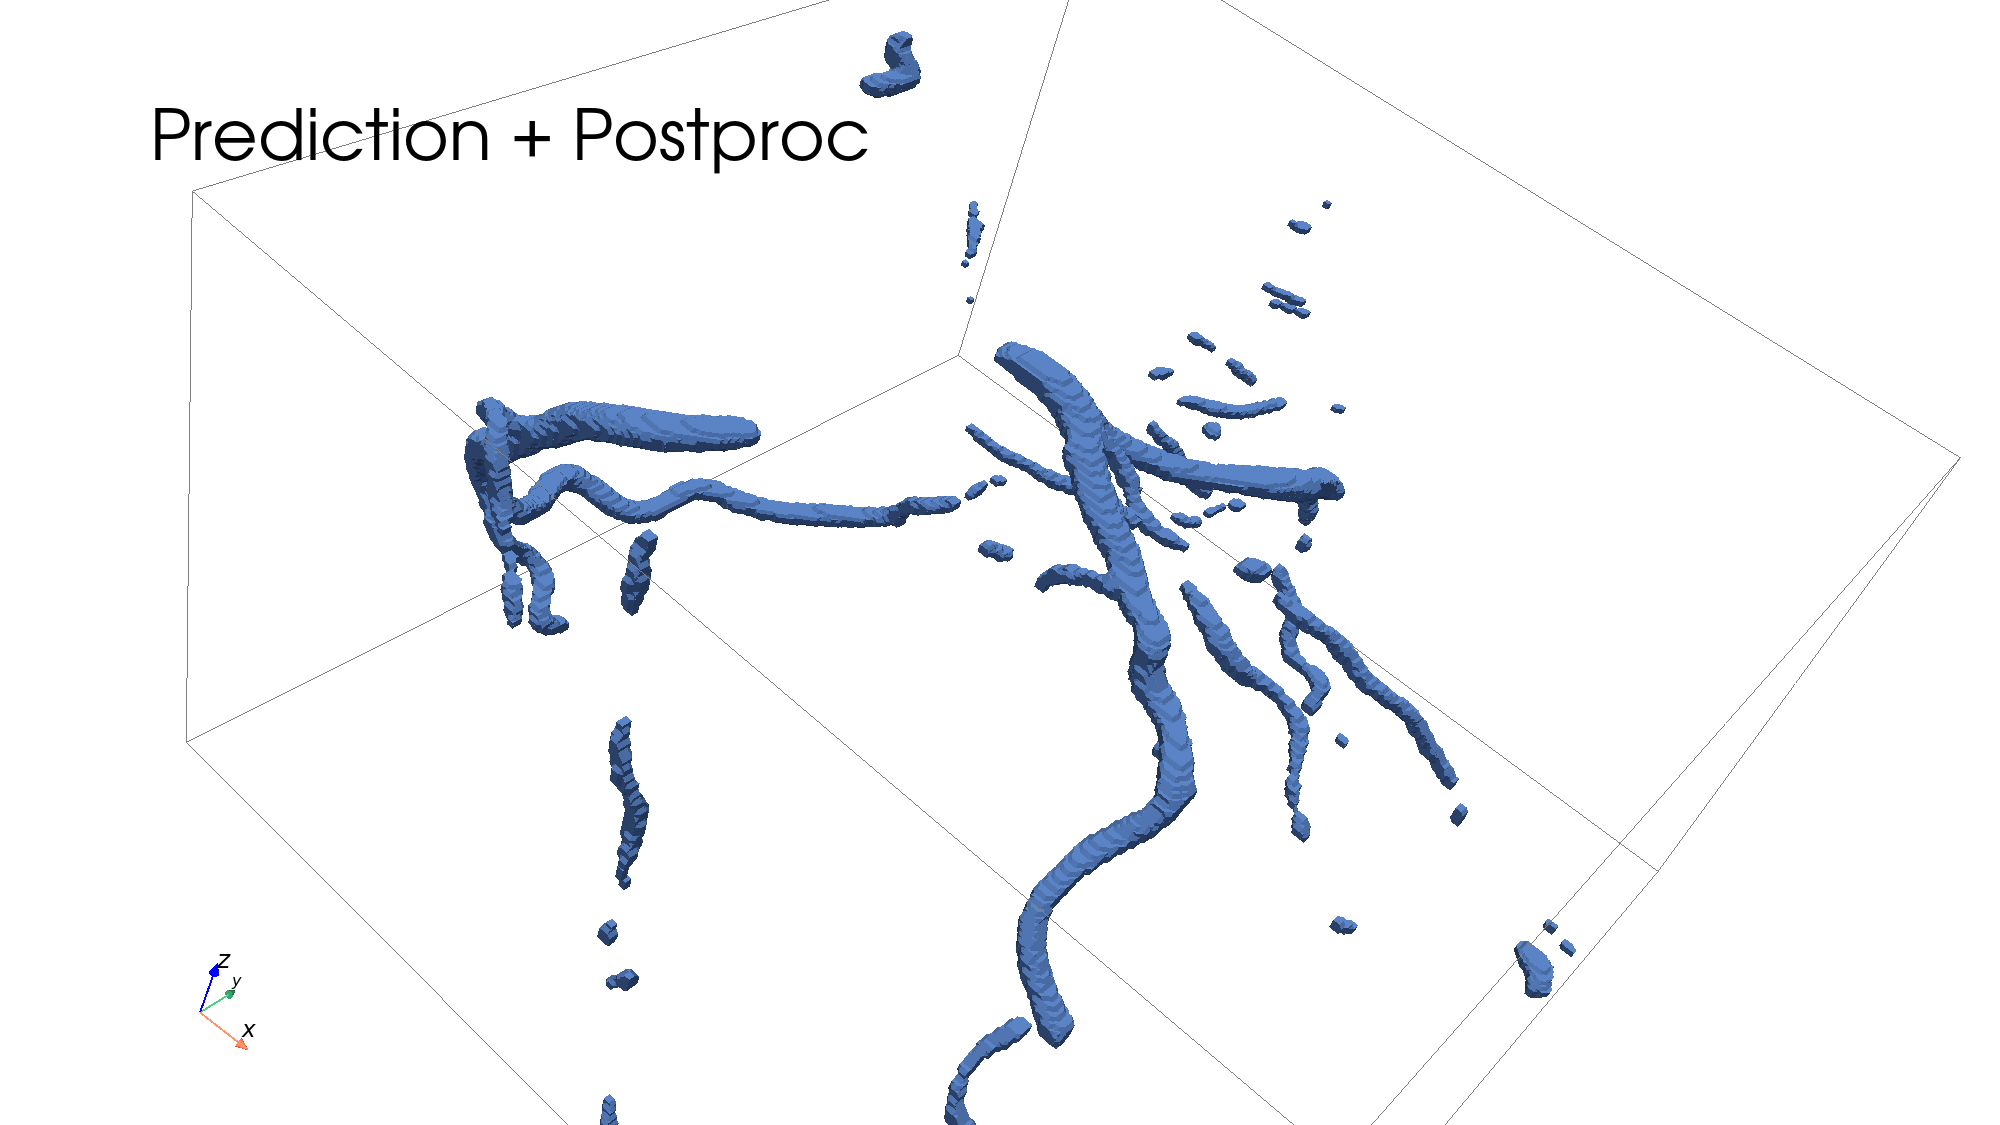

In [11]:
# Create a 3D mesh
mesh_3 = pv.wrap(np_ndarr)

# take only the detected aortas (value = 1)
contour_3 = mesh_3.contour([1], "values")

res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_3, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Prediction + Postproc", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

148

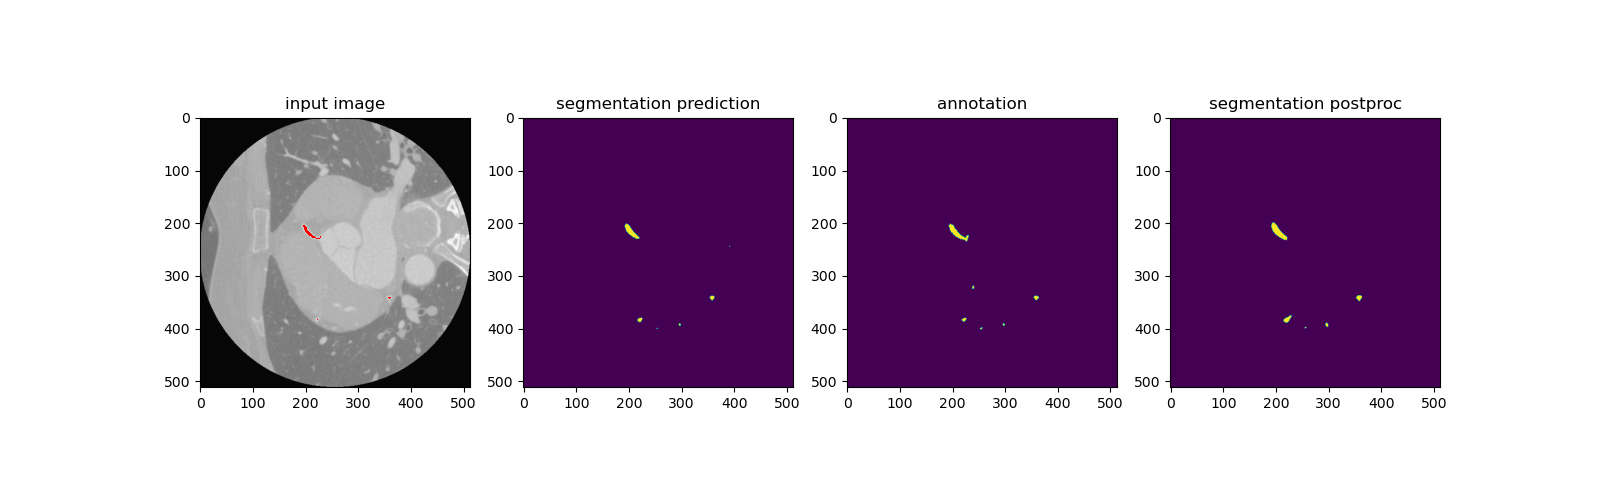

In [20]:
%matplotlib widget

i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")
arr = lbl[:,:,i].astype(float)
arr[arr == 0] = np.nan
axs[0].imshow(arr, cmap="bwr_r")

axs[1].set_title("segmentation prediction")
axs[1].imshow(pred[:,:,i], cmap="viridis")

axs[2].set_title("annotation")
axs[2].imshow(lbl[:,:,i], cmap="viridis")

axs[3].set_title("segmentation postproc")
# axs[3].imshow(np_ndarr[:,:,i], cmap="viridis")
axs[3].imshow(postprocessed_aorta_mask[:,:,i], cmap="viridis")


i

In [32]:
import numpy as np
from skimage import measure
from skimage import measure, morphology


def postprocess_aorta_segmentation(segmentation_mask, min_size_threshold):
    # # Thresholding
    # thresholded_mask = segmentation_mask > 0
    thresholded_mask = segmentation_mask

    # Connected Component Analysis
    labeled_mask, num_components = measure.label(thresholded_mask, connectivity=1, return_num=True)

    # Filtering Small Components
    for component_label in range(1, num_components + 1):
        component_size = np.sum(labeled_mask == component_label)
        if component_size < min_size_threshold:
            labeled_mask[labeled_mask == component_label] = 0

    # Optional: Region Growing
    # You can implement region growing here based on seed points within the aorta region.
    # For example, use aorta seed points to expand the segmentation.

    # Optional: Morphological Operations
    # Erosion to remove small protrusions
    # eroded_mask = morphology.binary_erosion(labeled_mask)
    # Dilation to fill gaps
    # dilated_mask = morphology.binary_dilation(eroded_mask)
    # labeled_mask = dilated_mask

    return labeled_mask


segmentation_result = pred  # segmentation ndarray
min_size_threshold = 200  # Adjust this based on your image resolution

postprocessed_aorta_mask = postprocess_aorta_segmentation(segmentation_result, min_size_threshold)

postprocessed_aorta_mask[postprocessed_aorta_mask>0] = 1

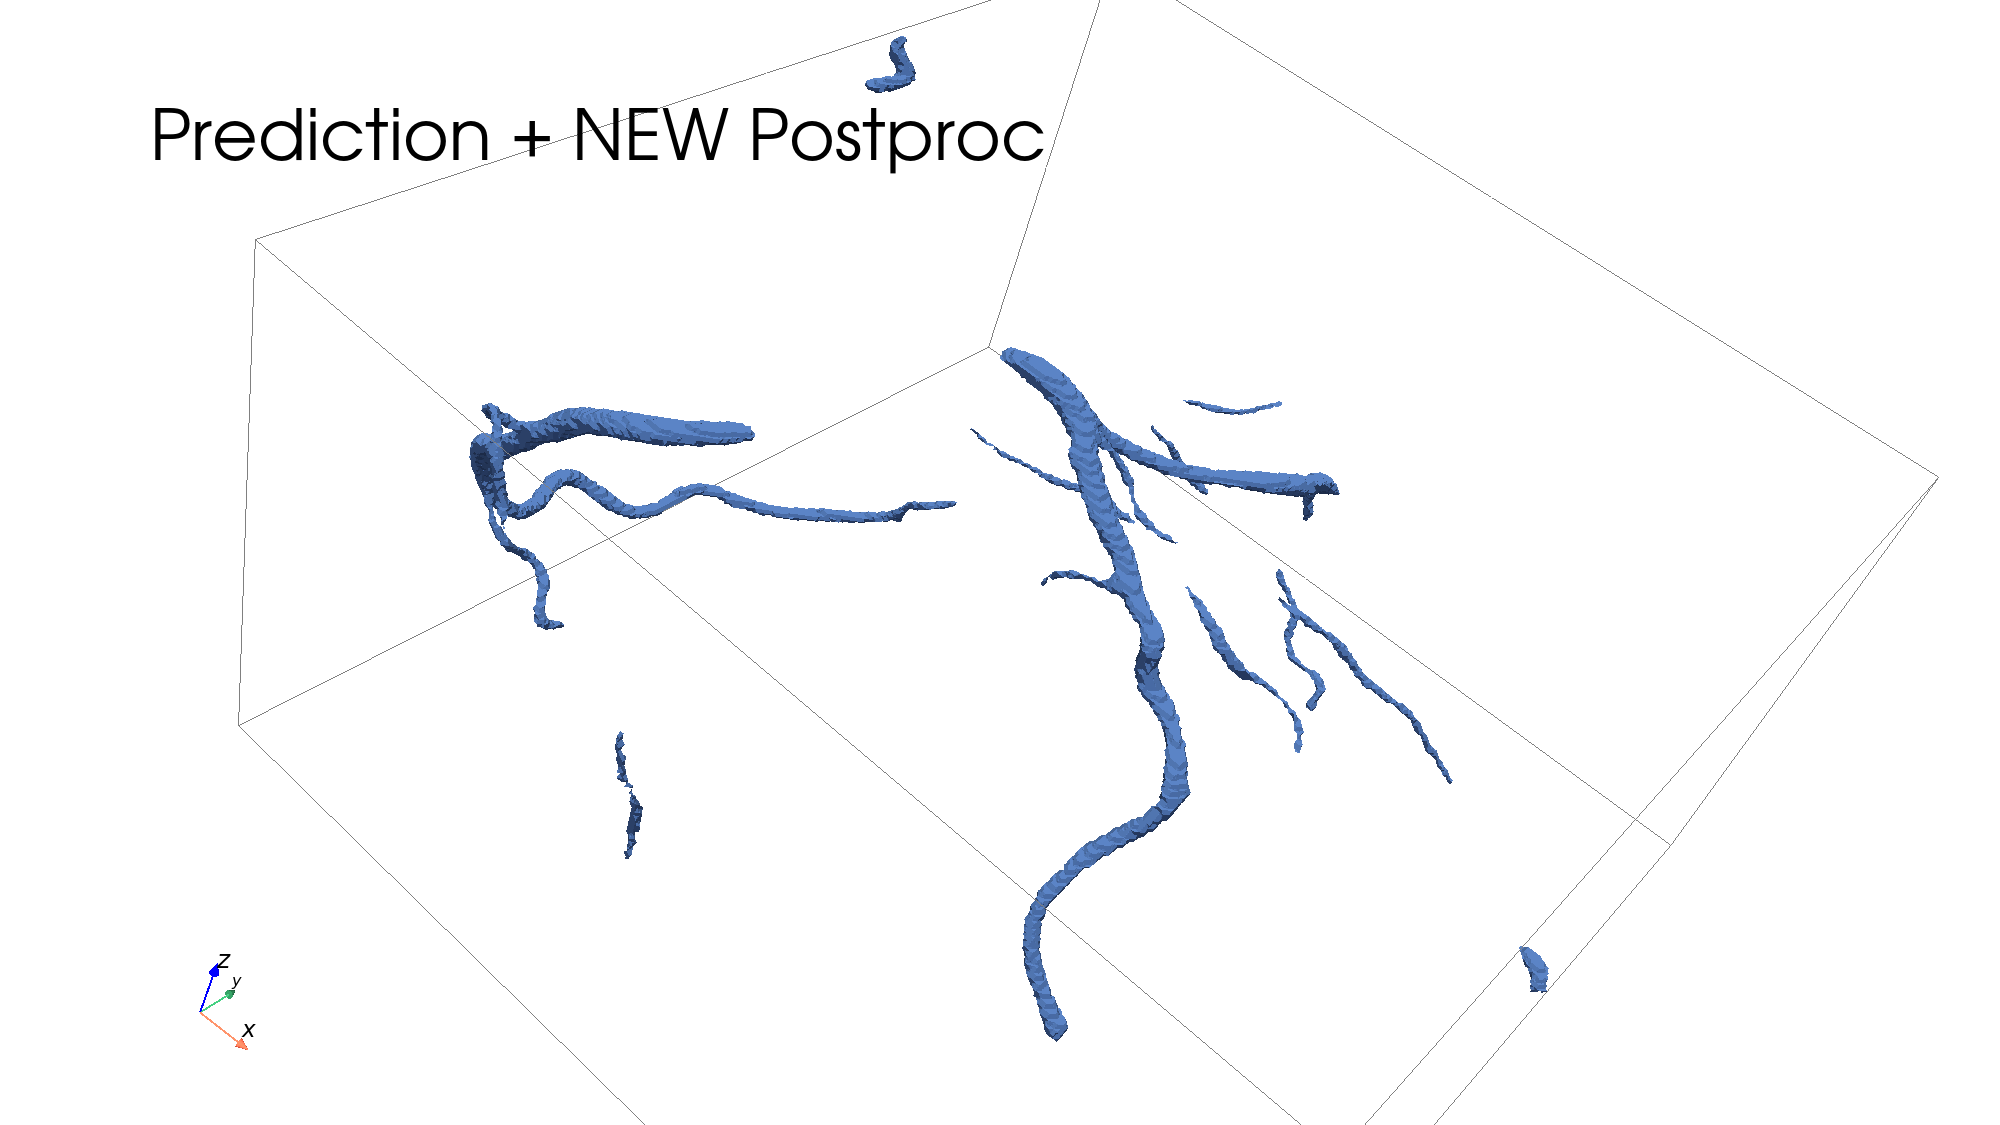

In [41]:
# Create a 3D mesh
mesh_3 = pv.wrap(postprocessed_aorta_mask)

# take only the detected aortas (value = 1)
contour_3 = mesh_3.contour([1], "values")

res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_3, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Prediction + NEW Postproc", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [24]:
## evaluate man HD95 (hausdorff distance) and dice score

def dice_coefficient(prediction, labels):
    # measures the overlap between the predicted segmentation and the ground truth
    intersection = np.sum(prediction * labels)
    union = np.sum(prediction) + np.sum(labels)
    dice = (2.0 * intersection) / (union + 1e-6)
    return dice


def hausdorff_metric(prediction, labels):
    # quantifies the maximum discrepancy between the predicted segmentation and the ground truth
    distances = []
    for i in range(prediction.shape[2]):
        d1 = directed_hausdorff(prediction[:, :, i], labels[:, :, i])[0]
        d2 = directed_hausdorff(labels[:, :, i], prediction[:, :, i])[0]
        distances.extend([d1, d2])
    distances.sort()
    percentile_95 = distances[int(0.95 * len(distances))]
    return percentile_95

In [28]:
# without postproc

mean_dice = np.mean([dice_coefficient(pred[:, :, i], lbl[:, :, i]) for i in range(pred.shape[2])])
mean_dice       # higher = better, best = 0.89 (ASOCA Challenge)

0.4395590417257778

In [29]:
hausdorff_95 = hausdorff_metric(pred, lbl)
hausdorff_95    # lower = better, best = 1.89 (ASOCA Challenge)

2.8284271247461903

In [42]:
# with postproc: makes it a bit better!!!
mean_dice = np.mean([dice_coefficient(postprocessed_aorta_mask[:, :, i], lbl[:, :, i]) for i in range(pred.shape[2])])
mean_dice

0.4553630544130115

In [43]:
hausdorff_95 = hausdorff_metric(postprocessed_aorta_mask, lbl)
hausdorff_95

2.6457513110645907